In [0]:

import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import sklearn.preprocessing
import matplotlib
import zipfile
from PIL import Image

In [0]:
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl
from PIL import Image, ImageOps
from os import scandir, getcwd
from os import listdir
import os
from os.path import isfile, join
import zipfile                          # Per importació a partir de ZIP
import io

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [60]:
!wget "https://github.com/gdsa-upc/2019-Equip4/raw/master/tb2108B.zip" -O Dades.zip

--2019-12-06 16:03:58--  https://github.com/gdsa-upc/2019-Equip4/raw/master/tb2108B.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gdsa-upc/2019-Equip4/master/tb2108B.zip [following]
--2019-12-06 16:03:59--  https://raw.githubusercontent.com/gdsa-upc/2019-Equip4/master/tb2108B.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2433646 (2.3M) [application/zip]
Saving to: ‘Dades.zip’

Dades.zip           100%[===================>]   2.32M  --.-KB/s    in 0.08s   

2019-12-06 16:03:59 (28.2 MB/s) - ‘Dades.zip’ saved [2433646/2433646]



In [0]:
f = zipfile.ZipFile("Dades.zip",'r')
for file in f.namelist():
    f.extract(file,"./Dades/")  # Guardar en el directori /Dades/
f.close()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = "./Dades/tb2108/tb2018"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [0]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

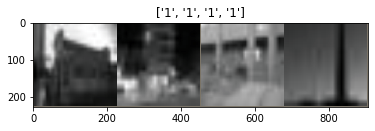

In [66]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [71]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Ep

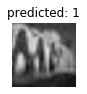

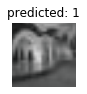

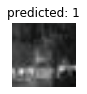

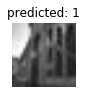

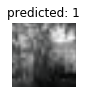

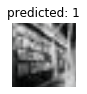

In [72]:
visualize_model(model_ft)